In [1]:
# import
import matplotlib.pyplot as plt
import numpy as np 
import pandas as pd 
import seaborn as sns
from pathlib import Path
from tqdm import tqdm

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import lightgbm 

In [2]:
# パラメータ
random_state = 20230729
valid_size = 0.30
test_size = 0.20

In [3]:
def argmax(l : list) -> int : 
    assert len(l) != 0 
    best_score = -1e10
    best_index = -1
    for i, score in enumerate(l) : 
        if score > best_score : 
            best_score = score 
            best_index = i
    return best_index

### 前処理

In [4]:
# dataをload
# data : https://www.kaggle.com/datasets/uciml/red-wine-quality-cortez-et-al-2009/code?datasetId=4458
# このipynbがあるディレクトリと同じディレクトリに"red_wine_quality.csv"という名前で置いておく
data_path = Path("./red_wine_quality.csv")
data = pd.read_csv(data_path)

# dataを調べる
print(data.head())
print(data.describe())
print(data["quality"].value_counts())
print(data.isnull().sum())   # 欠損値なし

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
0            7.4              0.70         0.00             1.9      0.076  \
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates   
0                 11.0                  34.0   0.9978  3.51       0.56  \
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

In [5]:
# データを分割
X = data.iloc[:, 0:-1]   # 説明変数
y = data.iloc[:, -1]   # 目的変数
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=valid_size + test_size, random_state=random_state)   # ラベルがばらけるようにしておく
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=(test_size / (valid_size + test_size)), random_state=random_state)

print(f'train_size : {len(X_train)}')
print(f'valid_size : {len(X_valid)}')
print(f'test_size  : {len(X_test)}')

# 正規化する（ニューラルネットワークで使う）
scaler = StandardScaler()
scaler.fit(X_train)
scaled_X_train = scaler.transform(X_train)
scaled_X_valid = scaler.transform(X_valid)
scaled_X_test = scaler.transform(X_test)

print(X_train.head())
print(y_train.value_counts())

train_size : 799
valid_size : 480
test_size  : 320
     fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
704            9.1             0.765         0.04             1.6      0.078  \
423           10.5             0.240         0.47             2.1      0.066   
36             7.8             0.600         0.14             2.4      0.086   
405            8.7             0.310         0.46             1.4      0.059   
548           12.4             0.350         0.49             2.6      0.079   

     free sulfur dioxide  total sulfur dioxide  density    pH  sulphates   
704                  4.0                  14.0   0.9980  3.29       0.54  \
423                  6.0                  24.0   0.9978  3.15       0.90   
36                   3.0                  15.0   0.9975  3.42       0.60   
405                 11.0                  25.0   0.9966  3.36       0.76   
548                 27.0                  69.0   0.9994  3.12       0.75   

     alcoho

#### 変数同士の相関を可視化

<Axes: >

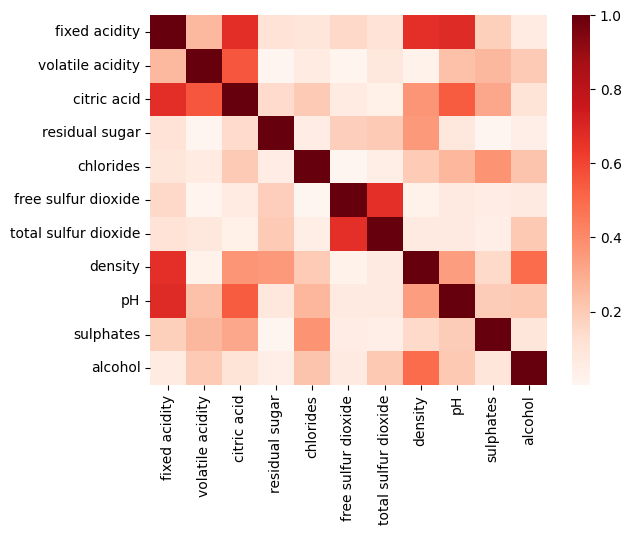

In [6]:
sns.heatmap(X.corr().abs(), cmap="Reds")

### いくつかの機械学習モデルを試してみる

#### ロジスティック回帰

In [7]:
# ロジスティック回帰

lr = LogisticRegression(max_iter=1000)   # エラーが出るのでデフォルトよりmax_iterを大きくしておく
lr.fit(X_train, y_train)

print(f'train_score : {accuracy_score(lr.predict(X_train), y_train)}')
print(f'test_score  : {accuracy_score(lr.predict(X_test), y_test)}')

train_score : 0.5957446808510638
test_score  : 0.6125


/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### サポートベクターマシン

100%|██████████| 200/200 [00:11<00:00, 17.05it/s]


best_valid_score : 0.5729


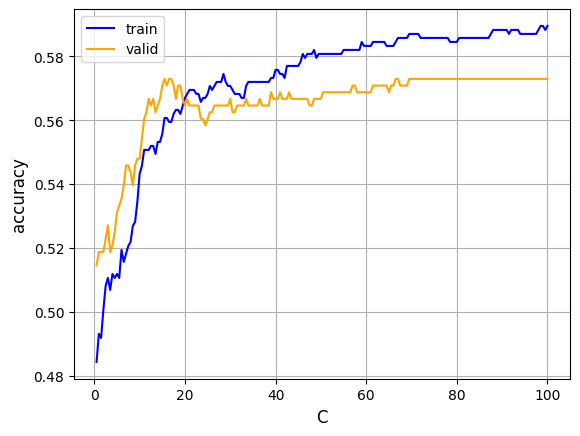

test_score : 0.59375


In [8]:
# サポートベクターマシン

C_list = [0.5 * i for i in range(1, 201)] 
train_accuracy_list = []
valid_accuracy_list = []
for C in tqdm(C_list) : 
    svc = SVC(C=C,
              # kernel="rbf",   # kernelを変えても意味なし 
              random_state=random_state)
    svc.fit(X_train, y_train)
    train_accuracy_list.append(accuracy_score(svc.predict(X_train), y_train))
    valid_accuracy_list.append(accuracy_score(svc.predict(X_valid), y_valid))

print(f'best_valid_score : {max(valid_accuracy_list):.4f}')
plt.grid()
plt.plot(C_list, train_accuracy_list, color="blue", label="train")
plt.plot(C_list, valid_accuracy_list, color="orange", label="valid")
plt.xlabel("C", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.legend()
plt.show()

best_C = C_list[argmax(valid_accuracy_list)]
svc = SVC(C=best_C,
          kernel="rbf", 
          random_state=random_state)
svc.fit(X_train, y_train)
print(f'test_score : {accuracy_score(svc.predict(X_test), y_test)}')

#### 決定木

GridSearchした方がなお良いが、時間がかかるので最もクリティカルなパラメータのみを調整する

100%|██████████| 64/64 [00:00<00:00, 126.57it/s]


best_valid_score : 0.5917


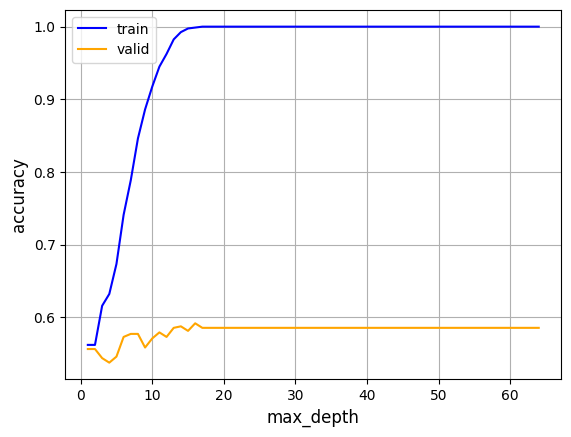

test_score : 0.59375


In [9]:
# 決定木

max_depth_list = [i for i in range(1, 65)]
train_accuracy_list = []
valid_accuracy_list = []
for max_depth in tqdm(max_depth_list) : 
    dtc = DecisionTreeClassifier(max_depth=max_depth, 
                                 random_state=random_state)
    dtc.fit(X_train, y_train)
    train_accuracy_list.append(accuracy_score(dtc.predict(X_train), y_train))
    valid_accuracy_list.append(accuracy_score(dtc.predict(X_valid), y_valid))

print(f'best_valid_score : {max(valid_accuracy_list):.4f}')
plt.grid()
plt.plot(max_depth_list, train_accuracy_list, color="blue", label="train")
plt.plot(max_depth_list, valid_accuracy_list, color="orange", label="valid")
plt.xlabel("max_depth", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.legend()
plt.show()

best_max_depth = max_depth_list[argmax(valid_accuracy_list)]
dtc = DecisionTreeClassifier(max_depth=best_max_depth, 
                             random_state=random_state)
dtc.fit(X_train, y_train)
print(f'test_score : {accuracy_score(dtc.predict(X_test), y_test)}')

#### LightGBM

100%|██████████| 30/30 [00:01<00:00, 17.12it/s]


best_valid_score : 0.6417


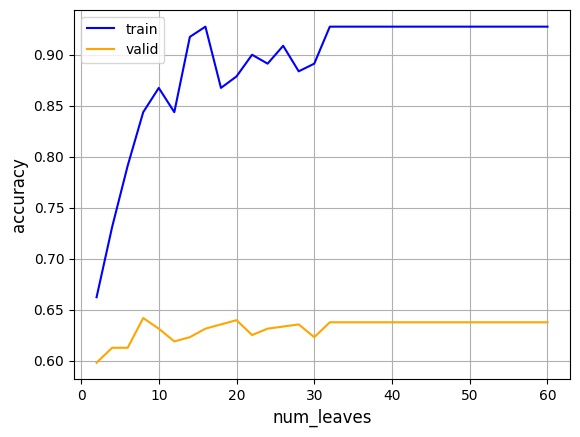

best_num_leaves : 8
test_score : 0.65


In [10]:
# lightGBM

num_leaves_list = [2 * i for i in range(1, 31)]
train_accuracy_list = []
valid_accuracy_list = []

# early_stoppingの仕様が、自分が勉強したときと変わっていたので以下のサイトを参考にした
# https://qiita.com/c60evaporator/items/2b7a2820d575e212bcf4 
for num_leaves in tqdm(num_leaves_list) : 
    lgb = lightgbm.LGBMClassifier(verbose=-1, 
                                  reg_lambda=0.1,   # reg_lambdaは大きめの方が良さそうだった
                                  num_leaves=num_leaves, 
                                  random_state=random_state)   
    lgb.fit(X_train, y_train,
            eval_set = [(X_valid, y_valid)], 
            callbacks=[lightgbm.early_stopping(stopping_rounds=20,
                                               verbose=False)])
    train_accuracy_list.append(accuracy_score(lgb.predict(X_train), y_train))
    valid_accuracy_list.append(accuracy_score(lgb.predict(X_valid), y_valid))

print(f'best_valid_score : {max(valid_accuracy_list):.4f}')
plt.grid()
plt.plot(num_leaves_list, train_accuracy_list, color="blue", label="train")
plt.plot(num_leaves_list, valid_accuracy_list, color="orange", label="valid")
plt.xlabel("num_leaves", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.legend()
plt.show()

# testの精度を表示する
best_num_leaves = num_leaves_list[argmax(valid_accuracy_list)]
print(f'best_num_leaves : {best_num_leaves}')
lgb = lightgbm.LGBMClassifier(verbose=-1, 
                              reg_lambda=0.1, 
                              num_leaves=best_num_leaves, 
                              random_state=random_state)
lgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)], 
        callbacks=[lightgbm.early_stopping(stopping_rounds=20,
                                           verbose=False)])
print(f'test_score : {accuracy_score(lgb.predict(X_test), y_test)}')

どう見ても過学習しているが、正則化項を大きくするとvalidの精度も下がってしまうので、過学習させたままにしておく

#### GradientBoostingTree

100%|██████████| 20/20 [00:37<00:00,  1.88s/it]

best_valid_score : 0.6646


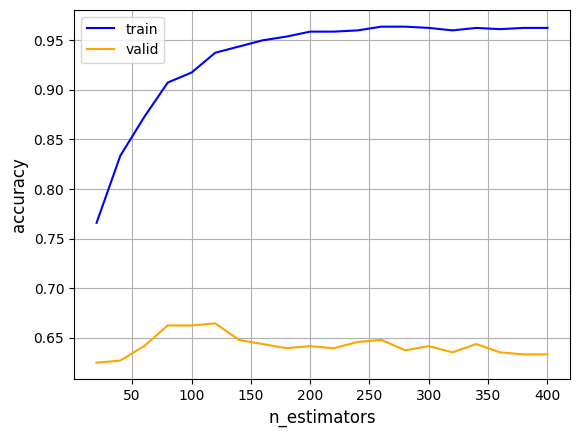

best_n_estimators : 120
test_score : 0.634375


In [11]:
# GradientBoostingTree

n_estimators_list = [20 * i for i in range(1, 21)]
train_accuracy_list = []
valid_accuracy_list = []

for n_estimators in tqdm(n_estimators_list) : 
    gbc = GradientBoostingClassifier(n_estimators=n_estimators, 
                                     n_iter_no_change=1000,   # 適当
                                     random_state=random_state)
    gbc.fit(X_train, y_train)
    train_accuracy_list.append(accuracy_score(gbc.predict(X_train), y_train))
    valid_accuracy_list.append(accuracy_score(gbc.predict(X_valid), y_valid))

print(f'best_valid_score : {max(valid_accuracy_list):.4f}')
plt.grid()
plt.plot(n_estimators_list, train_accuracy_list, color="blue", label="train")
plt.plot(n_estimators_list, valid_accuracy_list, color="orange", label="valid")
plt.xlabel("n_estimators", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.legend()
plt.show()

best_n_estimators = n_estimators_list[argmax(valid_accuracy_list)]
print(f'best_n_estimators : {best_n_estimators}')
gbc = GradientBoostingClassifier(n_estimators=best_n_estimators, 
                                 n_iter_no_change=1000,
                                 random_state=random_state)
gbc.fit(X_train, y_train)
print(f'test_score : {accuracy_score(gbc.predict(X_test), y_test)}')

#### ニューラルネットワーク（正則化なし）

  6%|▋         | 1/16 [00:00<00:14,  1.06it/s]/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
 12%|█▎        | 2/16 [00:02<00:14,  1.02s/it]/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
 19%|█▉        | 3/16 [00:03<00:14,  1.14s/it]/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
 25%|██▌       | 4/16 [00:04<00:14,  1.23s/it]/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/neural_network/_mu

best_valid_score : 0.6292


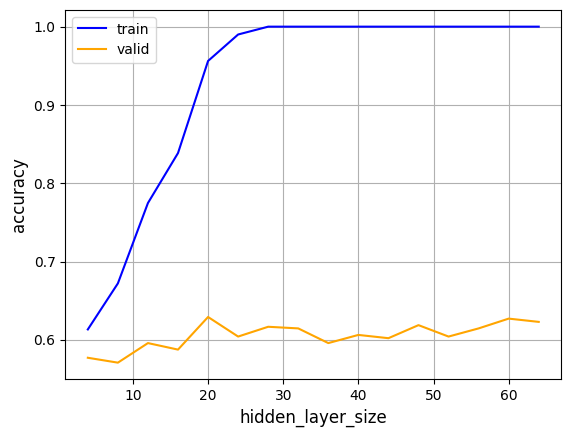

best_hidden_layer_size : 20
test_score : 0.59375


In [12]:
# ニューラルネットワーク（正則化なし）

hidden_layer_size_list = [4 * i for i in range(1, 17)]
train_accuracy_list = []
valid_accuracy_list = []

for hidden_layer_size in tqdm(hidden_layer_size_list) : 
    nn = MLPClassifier(hidden_layer_sizes=(hidden_layer_size, hidden_layer_size, hidden_layer_size), 
                       activation="relu",
                       max_iter=1000,   # デフォルトより大きめにしておく
                       # early_stopping=True,   # 悪化したのでearly_stoppingしない
                       random_state=random_state)
    nn.fit(scaled_X_train, y_train)
    train_accuracy_list.append(accuracy_score(nn.predict(scaled_X_train), y_train))
    valid_accuracy_list.append(accuracy_score(nn.predict(scaled_X_valid), y_valid))

print(f'best_valid_score : {max(valid_accuracy_list):.4f}')
plt.grid()
plt.plot(hidden_layer_size_list, train_accuracy_list, color="blue", label="train")
plt.plot(hidden_layer_size_list, valid_accuracy_list, color="orange", label="valid")
plt.xlabel("hidden_layer_size", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.legend()
plt.show()

best_hidden_layer_size = hidden_layer_size_list[argmax(valid_accuracy_list)]
print(f'best_hidden_layer_size : {best_hidden_layer_size}')
nn = MLPClassifier(hidden_layer_sizes=(hidden_layer_size, hidden_layer_size, hidden_layer_size), 
                   activation="relu",
                   max_iter=1000,   # デフォルトより大きめにしておく
                   # early_stopping=True,   # 悪化したのでearly_stoppingしない
                   random_state=random_state)
nn.fit(X_train, y_train)
print(f'test_score : {accuracy_score(nn.predict(X_test), y_test)}')

#### 正則化あり

  0%|          | 0/16 [00:00<?, ?it/s]

 12%|█▎        | 2/16 [00:01<00:11,  1.21it/s]/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
 19%|█▉        | 3/16 [00:02<00:13,  1.03s/it]/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
 25%|██▌       | 4/16 [00:04<00:14,  1.20s/it]/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
 38%|███▊      | 6/16 [00:07<00:12,  1.30s/it]/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/neural_network/_mu

best_valid_score : 0.6406


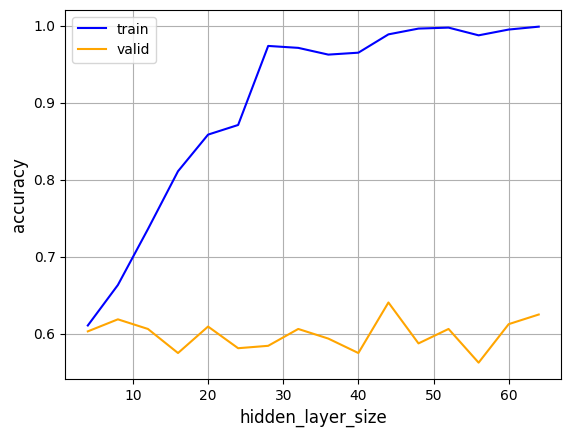

best_hidden_layer_size : 20
test_score : 0.6


In [13]:
# ニューラルネットワーク（正則化あり）

hidden_layer_size_list = [4 * i for i in range(1, 17)]
train_accuracy_list = []
test_accuracy_list = []

for hidden_layer_size in tqdm(hidden_layer_size_list) : 
    nn = MLPClassifier(hidden_layer_sizes=(hidden_layer_size, hidden_layer_size, hidden_layer_size), 
                       activation="relu",
                       max_iter=1000,   # デフォルトより大きめにしておく
                       alpha=0.5,  
                       # early_stopping=True,   # 悪化したのでearly_stoppingしない
                       random_state=random_state)
    nn.fit(scaled_X_train, y_train, )
    train_accuracy_list.append(accuracy_score(nn.predict(scaled_X_train), y_train))
    test_accuracy_list.append(accuracy_score(nn.predict(scaled_X_test), y_test))

print(f'best_valid_score : {max(test_accuracy_list):.4f}')
plt.grid()
plt.plot(hidden_layer_size_list, train_accuracy_list, color="blue", label="train")
plt.plot(hidden_layer_size_list, test_accuracy_list, color="orange", label="valid")
plt.xlabel("hidden_layer_size", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.legend()
plt.show()

best_hidden_layer_size = hidden_layer_size_list[argmax(valid_accuracy_list)]
print(f'best_hidden_layer_size : {best_hidden_layer_size}')
nn = MLPClassifier(hidden_layer_sizes=(hidden_layer_size, hidden_layer_size, hidden_layer_size), 
                   activation="relu",
                   max_iter=1000,   # デフォルトより大きめにしておく
                   # early_stopping=True,   # 悪化したのでearly_stoppingしない
                   alpha=0.5, 
                   random_state=random_state)
nn.fit(X_train, y_train)
print(f'test_score : {accuracy_score(nn.predict(X_test), y_test)}')

### 特徴量を変えてみる

In [14]:
# lightGBMのimportanceを確認する

lgb = lightgbm.LGBMClassifier(verbose=-1, 
                              reg_lambda=0.1, 
                              num_leaves=8, 
                              random_state=random_state)
lgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)], 
        callbacks=[lightgbm.early_stopping(stopping_rounds=20,
                                           verbose=False)])
print(f'train_score : {accuracy_score(lgb.predict(X_train), y_train)}')
print(f'valid_score : {accuracy_score(lgb.predict(X_valid), y_valid)}')
print(f'test_score  : {accuracy_score(lgb.predict(X_test), y_test)}')

importance_dict = {}   # key: col, val: importance
columns : list[str] = X_train.columns
for i in range(len(columns)) : 
    importance_dict[columns[i]] = lgb.feature_importances_[i]

# 重要度順にsort
importance_list = sorted(importance_dict.items(), reverse=True, key=lambda x : x[1])

# 結果をprint
print()
for x in importance_list : 
    print(f'{x[0]} : {x[1]}')

train_score : 0.8435544430538173
valid_score : 0.6416666666666667
test_score  : 0.65

alcohol : 207
volatile acidity : 183
sulphates : 175
chlorides : 145
total sulfur dioxide : 130
density : 126
pH : 113
citric acid : 89
fixed acidity : 87
residual sugar : 77
free sulfur dioxide : 71


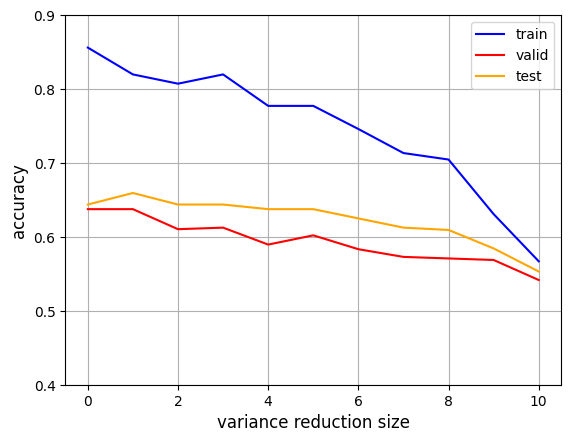

In [15]:
# importanceが低い特徴量を削ってみる

train_accuracy_list = []
valid_accuracy_list = []
test_accuracy_list = []

for i in range(11) :   # 削る数
    col_list = []   # 使う列
    for j in range(len(importance_list) - i) : 
        col_list.append(importance_list[j][0])
    lgb = lightgbm.LGBMClassifier(verbose=-1,
                                  reg_lambda=0.1, 
                                  num_leaves=8, 
                                  random_state=random_state)
    lgb.fit(X_train[col_list], y_train,
            eval_set=[(X_valid[col_list], y_valid)], 
            callbacks=[lightgbm.early_stopping(stopping_rounds=20,
                                               verbose=False)])
    
    train_accuracy_list.append(accuracy_score(lgb.predict(X_train[col_list]), y_train))
    valid_accuracy_list.append(accuracy_score(lgb.predict(X_valid[col_list]), y_valid))
    test_accuracy_list.append(accuracy_score(lgb.predict(X_test[col_list]), y_test))

plt.grid()
plt.ylim(0.4, 0.9)
plt.plot([i for i in range(11)], train_accuracy_list, color="blue", label="train")
plt.plot([i for i in range(11)], valid_accuracy_list, color="red", label="valid")
plt.plot([i for i in range(11)], test_accuracy_list, color="orange", label="test")
plt.xlabel("variance reduction size", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.legend()
plt.show()

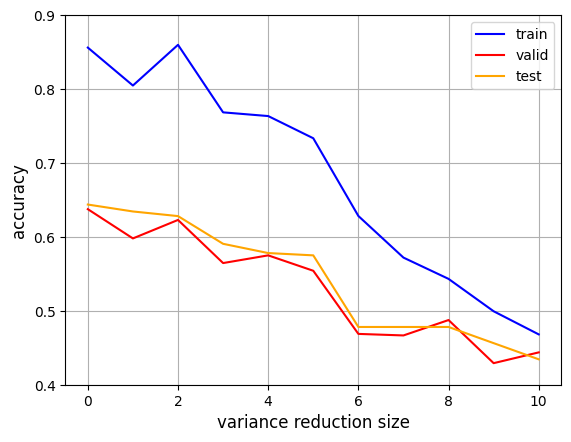

In [16]:
# importanceが高い特徴量を削ってみる

train_accuracy_list = []
valid_accuracy_list = []
test_accuracy_list = []

for i in range(11) :   # 削る数
    col_list = []   # 使う列
    for j in range(i, len(importance_list)) : 
        col_list.append(importance_list[j][0])
    lgb = lightgbm.LGBMClassifier(verbose=-1,
                                  reg_lambda=0.1, 
                                  num_leaves=8, 
                                  random_state=random_state)
    lgb.fit(X_train[col_list], y_train,
            eval_set=[(X_valid[col_list], y_valid)], 
            callbacks=[lightgbm.early_stopping(stopping_rounds=20,
                                               verbose=False)])
    
    train_accuracy_list.append(accuracy_score(lgb.predict(X_train[col_list]), y_train))
    valid_accuracy_list.append(accuracy_score(lgb.predict(X_valid[col_list]), y_valid))
    test_accuracy_list.append(accuracy_score(lgb.predict(X_test[col_list]), y_test))

plt.grid()
plt.ylim(0.4, 0.9)
plt.plot([i for i in range(11)], train_accuracy_list, color="blue", label="train")
plt.plot([i for i in range(11)], valid_accuracy_list, color="red", label="valid")
plt.plot([i for i in range(11)], test_accuracy_list, color="orange", label="test")
plt.xlabel("variance reduction size", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.legend()
plt.show()

特徴量の数を減らすと精度が下がる

LightGBMで重要ではない変数を減らしても効果が薄かったので、ニューラルネットワークで変数を減らしてみる

  0%|          | 0/11 [00:00<?, ?it/s]/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
 27%|██▋       | 3/11 [00:05<00:15,  1.95s/it]/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
 36%|███▋      | 4/11 [00:07<00:13,  1.97s/it]/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(
 64%|██████▎   | 7/11 [00:13<00:07,  1.81s/it]/home/notkamonohasi/.local/lib/python3.9/site-packages/sklearn/neural_network/_multilayer

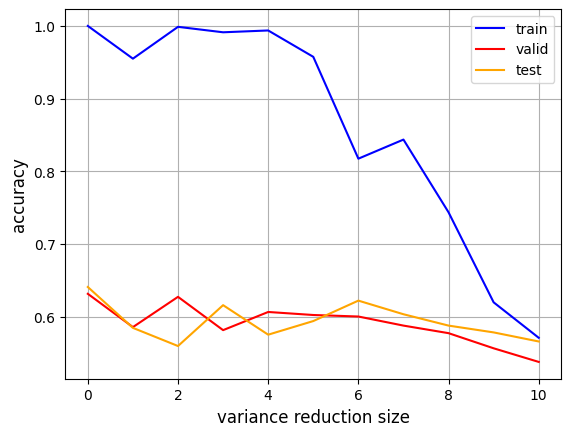

In [17]:
train_accuracy_list = []
valid_accuracy_list = []
test_accuracy_list = []

for i in tqdm(range(11)) :   # 削る数
    col_list = []   # 使う列
    for j in range(len(importance_list) - i) : 
        col_list.append(importance_list[j][0])
    nn = MLPClassifier(hidden_layer_sizes=(32, 32, 32), 
                       activation="relu",
                       max_iter=1000,   # デフォルトより大きめにしておく
                       # early_stopping=True,   # 悪化したのでearly_stoppingしない
                       random_state=random_state)
    
    # X_trainのサイズが変わるので、scalerを作り直す必要がある
    # 変数を変えたくないので、temp_...という名前にする
    temp_scaler = StandardScaler()
    temp_scaler.fit(X_train[col_list])
    temp_scaled_X_train = temp_scaler.transform(X_train[col_list])
    temp_scaled_X_valid = temp_scaler.transform(X_valid[col_list])
    temp_scaled_X_test = temp_scaler.transform(X_test[col_list])

    nn.fit(temp_scaled_X_train, y_train)
    train_accuracy_list.append(accuracy_score(nn.predict(temp_scaled_X_train), y_train))
    valid_accuracy_list.append(accuracy_score(nn.predict(temp_scaled_X_valid), y_valid))
    test_accuracy_list.append(accuracy_score(nn.predict(temp_scaled_X_test), y_test))

plt.grid()
plt.plot([i for i in range(11)], train_accuracy_list, color="blue", label="train")
plt.plot([i for i in range(11)], valid_accuracy_list, color="red", label="valid")
plt.plot([i for i in range(11)], test_accuracy_list, color="orange", label="test")
plt.xlabel("variance reduction size", fontsize=12)
plt.ylabel("accuracy", fontsize=12)
plt.legend()
plt.show()

## 分類を間違えた事例を確認する

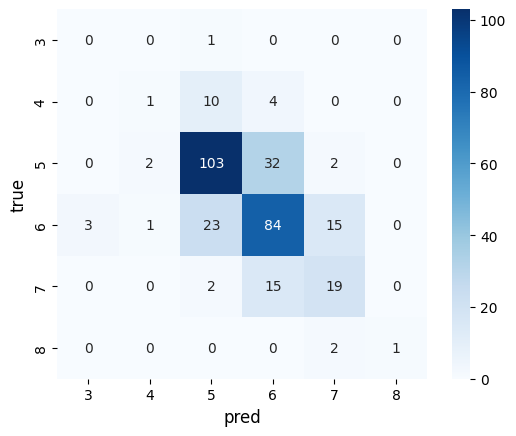

      fixed acidity  volatile acidity  citric acid  residual sugar  chlorides   
311             7.9             0.530         0.24             2.0      0.072  \
91              8.6             0.490         0.28             1.9      0.110   
910             9.3             0.380         0.48             3.8      0.132   
1467            6.7             1.040         0.08             2.3      0.067   
565            12.7             0.600         0.49             2.8      0.075   
...             ...               ...          ...             ...        ...   
729             6.4             0.865         0.03             3.2      0.071   
770             7.1             0.590         0.02             2.3      0.082   
404             7.7             0.690         0.05             2.7      0.075   
797             9.3             0.370         0.44             1.6      0.038   
481             9.4             0.300         0.56             2.8      0.080   

      free sulfur dioxide  

In [18]:
# モデルの学習
lgb = lightgbm.LGBMClassifier(verbose=-1, 
                              reg_lambda=0.1, 
                              num_leaves=8, 
                              random_state=random_state)
lgb.fit(X_train, y_train,
        eval_set=[(X_valid, y_valid)], 
        callbacks=[lightgbm.early_stopping(stopping_rounds=20,
                                           verbose=False)])

# 混同行列の作成
y_pred = lgb.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
cm_df = pd.DataFrame(cm, 
                     index=[i for i in range(3, 9)],
                     columns=[i for i in range(3, 9)])

# 可視化
# 可視化のコードはhttps://evaluelog.com/post-122/ を参考にした
sns.heatmap(cm_df, 
            square=True, 
            cbar=True, 
            annot=True, 
            fmt=".3g",
            cmap='Blues')
plt.xlabel("pred", fontsize=12)
plt.ylabel("true", fontsize=12)
plt.show()

# まちがっているデータを抜き出す
temp_df = X_test.copy(deep=True)
temp_df["true"] = y_test 
temp_df["pred"] = y_pred
temp_df = temp_df[temp_df["true"] != temp_df["pred"]]
print(temp_df)

見ても何も分からない...（これで分かったら機械学習いらないよね）

#### PCAで見てみる

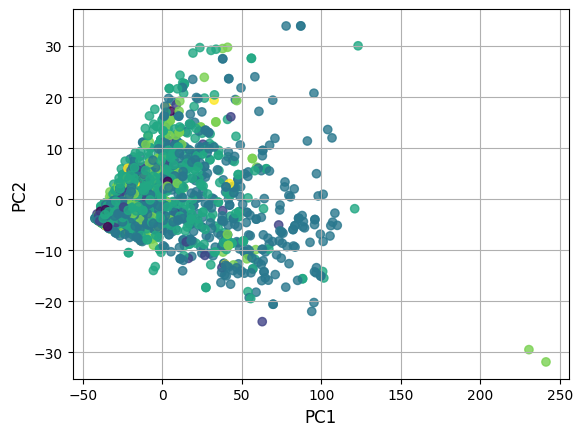

[9.46576976e-01 4.83683046e-02 2.58917183e-03 1.51896798e-03
 8.73553990e-04 3.45607218e-05 1.93627614e-05 9.47278079e-06
 8.41376628e-06 1.21472798e-06 4.68762788e-10]


In [19]:
# データを分割
X = data.iloc[:, 0:-1]   # 説明変数
y = data.iloc[:, -1]   # 目的変数

# 参考 : https://qiita.com/maskot1977/items/082557fcda78c4cdb41f
# PCA
pca = PCA()
pca.fit(X)

feature = pca.transform(X)

plt.scatter(feature[:, 0], feature[:, 1], alpha=0.8, c=list(y))
plt.grid()
plt.xlabel("PC1", fontsize=12)
plt.ylabel("PC2", fontsize=12)
plt.show()

print(pca.explained_variance_ratio_)

第一成分だけで94.7%ある。データの多様性が欠けている